## Distinguishing spheres using persistence landscapes

In this notebook, we will highlight some basic functionality of the `PersLandscapeApprox` class and how it can be used to perform a permutation test through a simple experiment. 

The experiment is to determine if persistent homology can distinguish between spheres of different dimensions. Here we restrict to differentiating $S^2$ from $S^3$. We will further restrict ourselves to persistent homology in degree one (but one can use all relevant homological degrees as well). A priori, we would not expect this to be an effective discriminator, since the ordinary first homology of both spheres is trivial. Note that this is a simplified version of the experiment from Bubenik and Dlotko's *A persistence landscapes toolbox for topological statistics* [1]. 

In detail: 
- Repeat the following `num_runs = 100` times:
  - Sample `num_pts = 100` points from the 2-sphere and the 3-sphere. We rescale the spheres so the average distance between the points on each sphere is approximately 1.
  - Compute the VR persistent homology (using `ripser`) and compute the associated landscapes. Store each of these landscapes.
  - Compute the average landscape for $S^2$ and $S^3$. Take the difference of these two, and finally compute its supremum norm. This yields a real number; call it `significance`.
- We have thus established a baseline significance and we will see if the labelling of landscapes by dimension of their underlying sphere is significant as follows. Repeat the following `num_perms = 1000` times:
  - Using the stored landscapes, randomly label half as belonging to class A and the other half as class B. 
  - Compute the average landscape of class A, the average landscape of class B. Compute their difference and its sup norm.
  - If the sup norm of a shuffled set of labels is larger than `significance`, then we say that particular shuffling of labels was significant. If the sup norm is smaller than `significance`, then that labelling was not significant.
  - Take the total number of significant labellings and divide by `num_perms` to get the p-value of this permutation test. If this p-value is less than some threshold (say 0.05), then we accept the hypothesis that the labelling based on the sphere's dimension is significant. Otherwise, we reject.

In [1]:
import numpy as np
import random

from ripser import ripser
from persim import (
    PersLandscapeApprox, 
    average_approx, 
    snap_PL, 
    plot_landscape, 
    plot_landscape_simple
)
from tadasets import dsphere

The aforementioned parameters taken from [1]. We modify these parameters below to speed up the computation.

In [2]:
num_pts = 100
num_runs = 100
num_perms = 1000

#### Establish the baseline

The following cell samples the points, computes the persistent homology and the landscapes. Depending on the above parameters, it could take a while.

We also scale the points according to the average distance between points on $S^2$ and $S^3$, respectively (given here https://math.stackexchange.com/q/2366580/22378). One could compute the actual distance on each run and normalize by that number, but that is more computationally intensive and isn't needed for this simple exercise. Note that `tadasets` implementation of `dsphere` samples points uniformly.

In [3]:
sph2_pl1 = []
sph3_pl1 = []

for _ in range(num_runs):
    sph2 = dsphere(n=num_pts, d=2)/1.3333 # sample points, scaling appropriately
    sph2_dgm = ripser(sph2, maxdim=2)['dgms'] # compute PH0, PH1, PH2
    sph2_pl = PersLandscapeApprox(dgms=sph2_dgm, hom_deg=1) # compute persistence landscape
    sph2_pl1.append(sph2_pl)
    
    sph3 = dsphere(n=num_pts, d=3)/1.3581 # sample points, scaling appropriately
    sph3_dgm = ripser(sph3, maxdim=2)['dgms'] # compute PH0, PH1, PH2
    sph3_pl = PersLandscapeApprox(dgms=sph3_dgm, hom_deg=1) # compute persistence landscape
    sph3_pl1.append(sph3_pl)


We now compute the average landscape of each list of landscapes. This can be done manually, but there is a method `average_approx` that will snap each entry to a common grid and compute the average efficiently.

In [4]:
avg_sph2 = average_approx(sph2_pl1)
avg_sph3 = average_approx(sph3_pl1)
print(avg_sph2, '\n') 
print(avg_sph3)

Approximate persistence landscape in homological degree 1 on grid from 0.08933579176664352 to 0.8012381196022034 with 500 steps 

Approximate persistence landscape in homological degree 1 on grid from 0.21182222664356232 to 0.8313391208648682 with 500 steps


Each of these average landscapes have been computed, but are on different grids, so we must first snapt them to a common grid before taking their difference.

In [5]:
[avg_sph2_snapped, avg_sph3_snapped] = snap_PL([avg_sph2, avg_sph3])
true_diff_pl = avg_sph2_snapped - avg_sph3_snapped
significance = true_diff_pl.sup_norm()

print(f'The threshold for significance is {significance}.')

The threshold for significance is 0.06311349068236712.


Can we see the differences qualititatively?

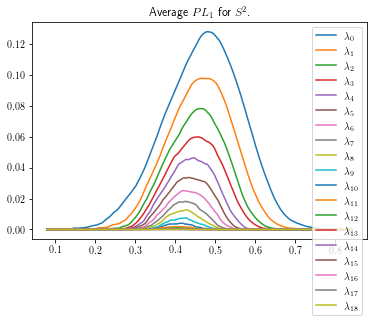

In [6]:
# view figures in notebook
# %matplotlib inline 

plot_landscape_simple(avg_sph2_snapped,title='Average $PL_1$ for $S^2$.')

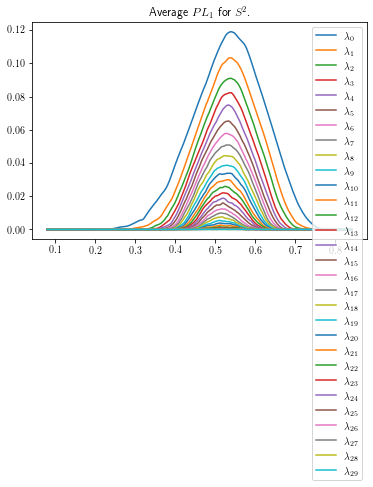

In [7]:
plot_landscape_simple(avg_sph3_snapped,title='Average $PL_1$ for $S^2$.')

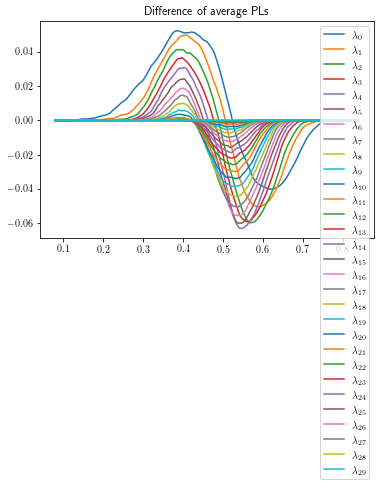

In [8]:
plot_landscape_simple(true_diff_pl,title='Difference of average PLs')

The last figure has a lot going on. We can try the 3d plotting method as well to see more depth. This method is slower, and better used for final figure and not exploration.

In [ ]:
plot_landscape(true_diff_pl,title='Difference of average PLs')

#### Perform the permutation test

In [ ]:
comb_pl = sph2_pl1 + sph3_pl1
sig_count = 0

for shuffle in range(num_perms):
    A_indices = random.sample(range(2*num_runs),num_runs)
    B_indices = [_ for _ in range(2*num_runs) if _ not in A_indices]
    
    A_pl = [comb_pl[i] for i in A_indices]
    B_pl = [comb_pl[j] for j in B_indices]
    
    A_avg = average_approx(A_pl)
    B_avg = average_approx(B_pl)
    [A_avg_sn, B_avg_sn] = snap_PL([A_avg,B_avg])
    
    shuff_diff = A_avg_sn - B_avg_sn
    if (shuff_diff.sup_norm() >= significance): sig_count += 1

pval = sig_count/num_perms

print(f'There were {sig_count} shuffles out of {num_perms} that',
     'were more significant than the true labelling. Thus, the',
     f'p-value is {pval}.')

So there wasn't a single run of our experiment that resulted in a more significant labelling than the original one based on each sphere's dimension! Therefore we conclude there is a strong statistical difference between the persistence landscapes in dimensions 2 and 3.

#### References

[1] Bubenik, P. & Dlotko, P. A persistence landscapes toolbox for topological statistics. Journal of Symbolic Computation **78**, 91–114 (2017).
